# VibeCheck-AI

[Dataset]("https://www.kaggle.com/datasets/kushagra3204/sentiment-and-emotion-analysis-dataset")

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import pos_tag

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_validate, train_test_split

In [2]:
# # Run this cell only if you get any nlkt errors:
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('omw-1.4')
# nltk.download('punkt_tab')

# # In case none of the previous one works:
# nltk.download()

## Exploratory Analysis

In [3]:
df_combined_emotion = pd.read_csv('raw_data/combined_emotion.csv')
df_combined_sentiment = pd.read_csv('raw_data/combined_sentiment_data.csv')

print(df_combined_emotion.shape, df_combined_sentiment.shape)

(422746, 2) (3309, 2)


In [4]:
print("Combined Emotion Dataframe")
df_combined_emotion.head(10)

Combined Emotion Dataframe


,sentence,emotion
0,i just feel really helpless and heavy hearted,fear
1,ive enjoyed being able to slouch about relax a...,sad
2,i gave up my internship with the dmrg and am f...,fear
3,i dont know i feel so lost,sad
4,i am a kindergarten teacher and i am thoroughl...,fear
5,i was beginning to feel quite disheartened,sad
6,i would think that whomever would be lucky eno...,love
7,i fear that they won t ever feel that deliciou...,joy
8,im forever taking some time out to have a lie ...,suprise
9,i can still lose the weight without feeling de...,sad


In [5]:
print("Combined Sentiment Dataframe")
df_combined_sentiment.head(10)

Combined Sentiment Dataframe


,sentence,sentiment
0,So there is no way for me to plug it in here i...,negative
1,"Good case, Excellent value.",positive
2,Great for the jawbone.,positive
3,Tied to charger for conversations lasting more...,negative
4,The mic is great.,positive
5,I have to jiggle the plug to get it to line up...,negative
6,If you have several dozen or several hundred c...,negative
7,If you are Razr owner...you must have this!,positive
8,"Needless to say, I wasted my money.",negative
9,What a waste of money and time!.,negative


In [6]:
# We dont want the combined sentiment dataset
del(df_combined_sentiment)
del(df_combined_emotion)

In [7]:
df = pd.read_csv("raw_data/combined_emotion.csv")
df.duplicated().sum()

np.int64(6623)

In [8]:
print(f"Shape before droping duplcates: {df.shape}")
df.drop_duplicates(inplace=True)
df.duplicated().sum()
print("-"*100)
print(f"Shape after droping duplcates: {df.shape}")

Shape before droping duplcates: (422746, 2)
----------------------------------------------------------------------------------------------------
Shape after droping duplcates: (416123, 2)


In [9]:
# Emotions distribution in absolute values
df['emotion'].value_counts()

emotion
joy        140779
sad        120989
anger       57235
fear        47664
love        34497
suprise     14959
Name: count, dtype: int64

In [10]:
# Emotions distribution in percentage
df['emotion'].value_counts(normalize=True).round(3)

emotion
joy        0.338
sad        0.291
anger      0.138
fear       0.115
love       0.083
suprise    0.036
Name: proportion, dtype: float64

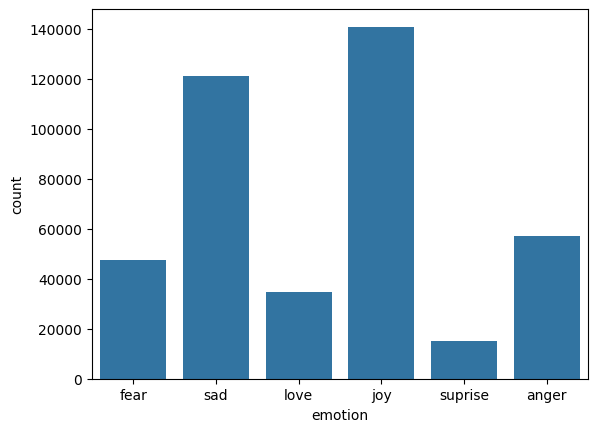

In [11]:
sns.countplot(x = df['emotion']);

In [12]:
# Balancing classes
emotions = list(df['emotion'].unique())
samples = {}

for emotion in emotions:
    if emotion == 'surprise':
        samples[emotion] = df[df['emotion'] == emotion]
    else:
        samples[emotion] = df[df['emotion'] == emotion].sample(14959)

In [13]:
df_balanced = pd.concat((samples['sad'], samples['love'], \
    samples['joy'], samples['fear'], samples['anger'],samples['suprise']))

In [14]:
print(f"Unbalanced dataframe shape: {df.shape}")
print(f"Balanced dataframe shape: {df_balanced.shape}")
print(f"Columns lost: {df.shape[0]-df_balanced.shape[0]}")

Unbalanced dataframe shape: (416123, 2)
Balanced dataframe shape: (89754, 2)
Columns lost: 326369


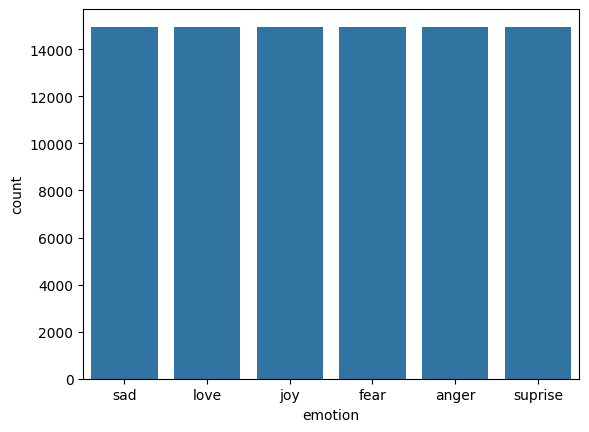

In [15]:
sns.countplot(x = df_balanced['emotion']);

In [16]:
def generate_wordcloud(text, title):
    stopwords = set(STOPWORDS)
    stopwords.update(["im", "feel", "feeling", 'will','really', 'know', 'time']) # removing commom words to all emotions
    wordcloud = WordCloud(width=800, height=400, background_color="white", stopwords=stopwords).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()

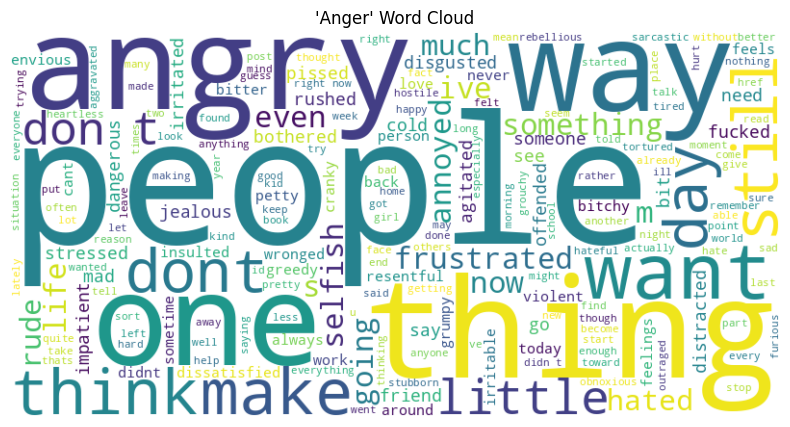

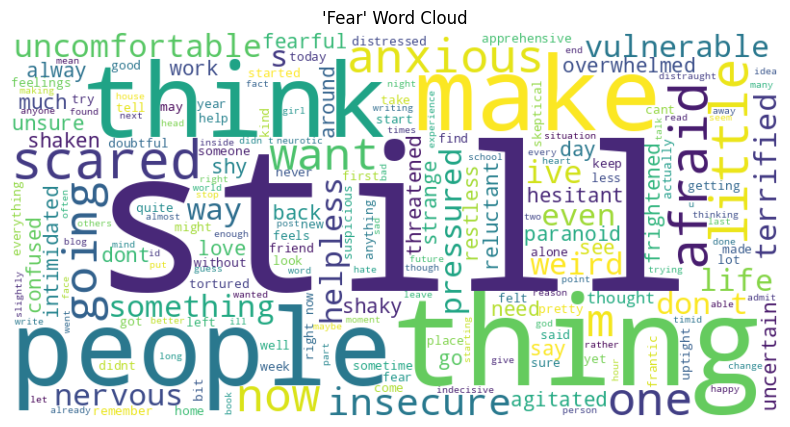

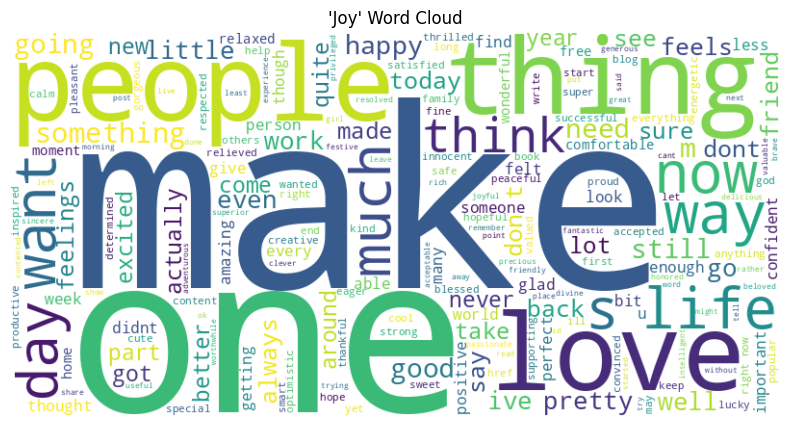

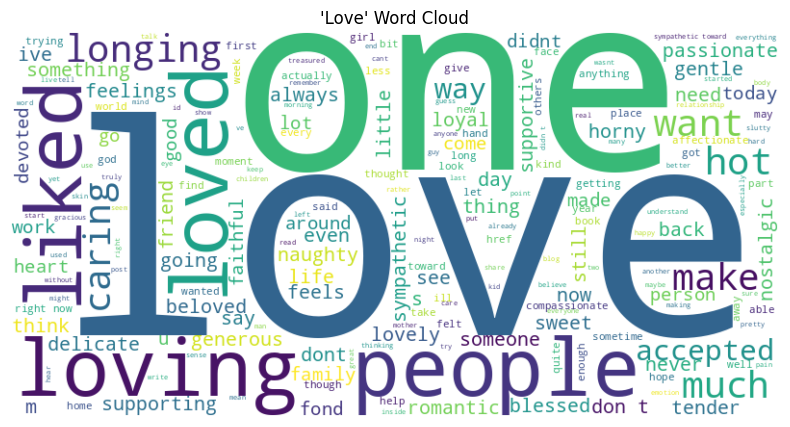

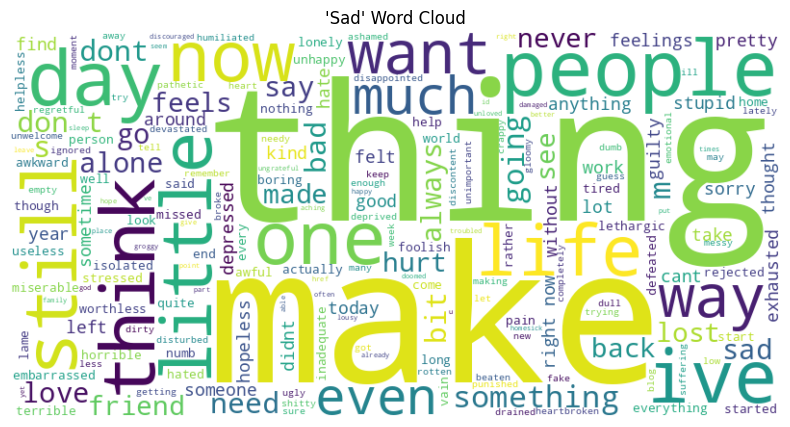

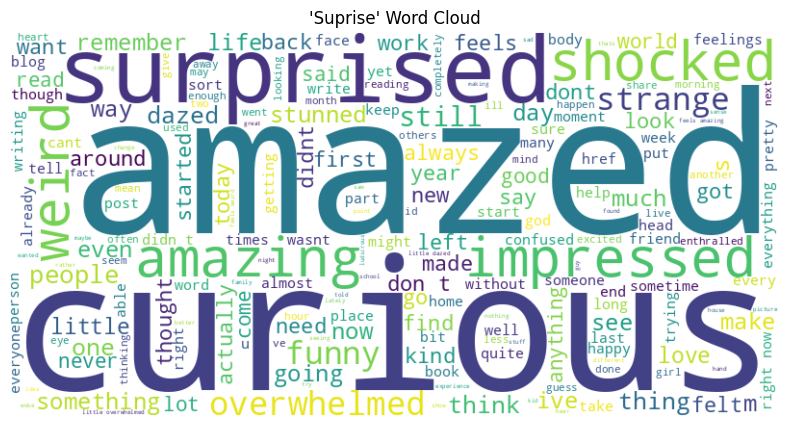

In [17]:
grouped_texts = df_balanced.groupby("emotion")['sentence'].apply(" ".join)
for sentiment, text in grouped_texts.items():
    generate_wordcloud(text, f"'{sentiment.capitalize()}' Word Cloud")

## Preprocessing

### Preparing text

In [18]:
class Cleaning:
    """
    A utility class for cleaning textual data by applying various cleaning operations.
    """
    PUNCTUATION = string.punctuation

    @staticmethod
    def to_lowercase(sentence:str)->str:
        """
        Convert all characters in the sentence to lowercase.

        Args:
            sentence (str): The input sentence.

        Returns:
            str: The sentence with all characters in lowercase.
        """
        if not isinstance(sentence, str):
            raise ValueError("Input must be a string")
        return sentence.lower()

    @staticmethod
    def remove_numbers(sentence:str)->str:
        """
        Remove all numeric characters from the sentence.

        Args:
            sentence (str): The input sentence.

        Returns:
            str: The sentence without numeric characters.
        """
        if not isinstance(sentence, str):
            raise ValueError("Input must be a string")
        return ''.join(char for char in sentence if not char.isdigit())

    @staticmethod
    def remove_punctuation(sentence:str)->str:
        """
        Remove all punctuation characters from the sentence.

        Args:
            sentence (str): The input sentence.

        Returns:
            str: The sentence without punctuation.
        """
        if not isinstance(sentence, str):
            raise ValueError("Input must be a string")
        return ''.join(char for char in sentence if char not in Cleaning.PUNCTUATION)

    @staticmethod
    def strip_spaces(sentence:str)->str:
        """
        Remove leading and trailing spaces from the sentence.

        Args:
            sentence (str): The input sentence.

        Returns:
            str: The sentence without leading and trailing spaces.
        """
        if not isinstance(sentence, str):
            raise ValueError("Input must be a string")
        return sentence.strip()

    @classmethod
    def full_cleaning(cls, sentence:str)->str:
        """
        Apply all preprocessing steps: lowercase conversion,
        removal of numbers, punctuation, and extra spaces.

        Args:
            sentence (str): The input sentence.

        Returns:
            str: The fully cleaned sentence.
        """
        if not isinstance(sentence, str):
            raise ValueError("Input must be a string")
        sentence = cls.to_lowercase(sentence)
        sentence = cls.remove_numbers(sentence)
        sentence = cls.remove_punctuation(sentence)
        sentence = cls.strip_spaces(sentence)
        return sentence

In [19]:
class Preprocessing:
    """
    A utility class for preprocessing textual data by applying various operations, including
    tokenization, removal of stopwords, and lemmatization.

    This class provides methods to:
    - Tokenize a sentence and remove stopwords.
    - Lemmatize tokens with part-of-speech tagging.
    - Combine tokenization and lemmatization into a single preprocessing step.
    """

    @staticmethod
    def tokenizer(sentence: str) -> list:
        """
        Tokenize a sentence and remove stopwords.

        This method tokenizes the input sentence into words and filters out common stopwords
        (such as "the", "is", "in", etc.) from the English language. It preserves line breaks
        when tokenizing.

        Args:
            sentence (str): The input sentence.

        Returns:
            list: A list of words from the sentence with stopwords removed.

        Raises:
            ValueError: If the input is not a string.
        """
        if not isinstance(sentence, str):
            raise ValueError("Input must be a string")

        # Get the list of stopwords from the nltk library
        stop_words = set(stopwords.words("english"))

        # Tokenize the sentence, preserving line breaks
        tokens = word_tokenize(sentence, preserve_line=True)

        # Remove stopwords from the tokenized list
        sentence = [w for w in tokens if w.lower() not in stop_words]

        return sentence

    @staticmethod
    def get_wordnet_pos(word: str) -> dict:
        """
        Get the part-of-speech (POS) tag for a word and map it to WordNet's POS format.

        This method uses the NLTK's part-of-speech tagger to identify the POS tag of the word
        and then maps it to WordNet's POS tags. WordNet uses 'n' for nouns, 'v' for verbs,
        'r' for adverbs, 'a' for adjectives, and 's' for satellite adjectives.

        Args:
            word (str): The word whose POS tag is to be identified.

        Returns:
            dict: A dictionary mapping the word to its POS tag in WordNet format.

        Raises:
            ValueError: If the input is not a string.
        """
        if not isinstance(word, str):
            raise ValueError("Input must be a string")

        target_word = pos_tag([word])[0][0]
        pos = pos_tag([word])[0][1][0].lower()

        # If the POS tag is not one of the known categories, default to noun ('n')
        if pos not in ['n', 'a', 'r', 'v', 's']:
            pos = 'n'

        return {target_word: pos}

    @classmethod
    def lemmatizer(cls, sentence: list) -> str:
        """
        Lemmatize the words in a list of tokens and join them into a sentence.

        This method reduces words to their base or dictionary form (lemmas), using the part-of-speech
        tags to improve accuracy. For example, turning "running" into "run" or "better" into "good".

        Args:
            sentence (list): A list of words (tokens) to be lemmatized.

        Returns:
            str: A sentence formed by joining the lemmatized words.

        Raises:
            ValueError: If the input is not a list.
        """
        if not isinstance(sentence, list):
            raise ValueError("Input must be a list")

        # Get POS tags for each word in the sentence
        tags = [cls.get_wordnet_pos(word) for word in sentence]

        lemmatized_sentence = []
        for d in tags:
            for word, pos in d.items():
                lemmatized_sentence.append(WordNetLemmatizer().lemmatize(word, pos))

        # Join the lemmatized words into a single sentence
        sentence = ' '.join(lemmatized_sentence)

        return sentence

    @classmethod
    def preprocessor(cls, sentence: str) -> str:
        """
        Apply tokenization and lemmatization on the input sentence.

        This method combines both the `tokenizer` and `lemmatizer` methods
        to preprocess the input sentence, returning the cleaned and lemmatized result.

        Args:
            sentence (str): The input sentence to be processed.

        Returns:
            str: The fully processed sentence.

        Raises:
            ValueError: If the input is not a string.
        """
        if not isinstance(sentence, str):
            raise ValueError("Input must be a string")

        # Tokenize the sentence
        sentence = cls.tokenizer(sentence)

        # Lemmatize the tokenized sentence
        sentence = cls.lemmatizer(sentence)

        return sentence

In [20]:
df_processed = df.copy()

df_processed['cleaned_sentence'] = df_processed['sentence'].apply(Cleaning.full_cleaning)
df_processed['preprocessed_sentence'] = df_processed['cleaned_sentence'].apply(Preprocessing.preprocessor)
df_processed.head(3)

,sentence,emotion,cleaned_sentence,preprocessed_sentence
0,i just feel really helpless and heavy hearted,fear,i just feel really helpless and heavy hearted,feel really helpless heavy hearted
1,ive enjoyed being able to slouch about relax a...,sad,ive enjoyed being able to slouch about relax a...,ive enjoy able slouch relax unwind frankly nee...
2,i gave up my internship with the dmrg and am f...,fear,i gave up my internship with the dmrg and am f...,give internship dmrg feel distraught


In [21]:
df_balanced_processed = df_balanced.copy()
df_balanced_processed['cleaned_sentence'] = df_balanced_processed['sentence'].apply(Cleaning.full_cleaning)
df_balanced_processed['preprocessed_sentence'] = df_balanced_processed['cleaned_sentence'].apply(Preprocessing.preprocessor)
df_balanced_processed.head(3)

,sentence,emotion,cleaned_sentence,preprocessed_sentence
281293,i listen when he tells me he has an ominous fe...,sad,i listen when he tells me he has an ominous fe...,listen tell ominous feel ignore time want see ...
353226,i often refer people i meet in the course of m...,sad,i often refer people i meet in the course of m...,often refer people meet course duty feel victi...
49969,i expected it to be a really tiring and diffic...,sad,i expected it to be a really tiring and diffic...,expect really tire difficult experience actual...


In [27]:
# Saving new dataframes

df_processed.drop(columns=['sentence', 'cleaned_sentence'],inplace=True)
df_processed = df_processed.sample(frac=1).reset_index(drop=True)#.drop(columns=['Unnamed: 0']) # Shuffle dataframe
df_processed.to_csv('raw_data/preprocessed_combined_emotion.csv')

df_balanced_processed.drop(columns=['sentence', 'cleaned_sentence'],inplace=True)
df_balanced_processed = df_balanced_processed.sample(frac=1).reset_index(drop=True)#.drop(columns=['Unnamed: 0']) # Shuffle dataframe
df_balanced_processed.to_csv('raw_data/balanced_preprocessed_combined_emotion.csv')

In [30]:
df_processed = pd.read_csv('raw_data/preprocessed_combined_emotion.csv').drop(columns=['Unnamed: 0'])
df_balanced_processed = pd.read_csv('raw_data/balanced_preprocessed_combined_emotion.csv').drop(columns=['Unnamed: 0'])

print(list(df_processed.columns), list(df_balanced_processed.columns))

['emotion', 'preprocessed_sentence'] ['emotion', 'preprocessed_sentence']


### Preprocessing

In [35]:
# Removing NA rows generated by preprocessing
df_balanced_processed.dropna(inplace=True)

In [36]:
tf_idf_vectorizer = TfidfVectorizer(min_df=5)

texts = [text for text in df_balanced_processed['preprocessed_sentence'].dropna()]
X = pd.DataFrame(tf_idf_vectorizer.fit_transform(texts).toarray(),
                 columns = tf_idf_vectorizer.get_feature_names_out())

X.shape

(89750, 7730)

In [74]:
y = df_balanced_processed[['emotion']].copy()
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

mapping_dict = {encoded: original for original, encoded in zip(label_encoder.classes_, range(len(label_encoder.classes_)))}
print(mapping_dict)

{0: 'anger', 1: 'fear', 2: 'joy', 3: 'love', 4: 'sad', 5: 'suprise'}


/home/brunovsf/.pyenv/versions/3.10.6/envs/vibecheck-ai/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
X_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

## Model

In [52]:
nb_model = MultinomialNB()

nb_cv = cross_validate(nb_model, X, y, cv=5, scoring=['accuracy'])
print(f"Cross-Val score: {nb_cv['test_accuracy'].mean()}")

nb_model.fit(X_train, y_train)

In [79]:
teste = ["I can't believe this is happening!"]
tf_idf_vectorizer.transform(teste)
mapping_dict.get(nb_model.predict(tf_idf_vectorizer.transform(teste))[0])

'suprise'

In [85]:
nb_model.predict_proba(tf_idf_vectorizer.transform(teste))

array([[0.13357519, 0.16174647, 0.17109919, 0.14497816, 0.11976974,
        0.26883125]])